In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2024-04-10 20:34:39.087848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-10 20:34:40.593516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data = np.load('WGAN_training_metrics_compressed.npz')
crit_loss_avg = data['crit_loss_avg']
gen_loss_avg = data['gen_loss_avg']
baseline = data['baseline']
performance_metric = data['performance_metric']
X_test_truth = data['X_test_truth']
Y_test = data['Y_test']
substructure_variables = ['w', 'q', 'm', 'r', 'tau1s', 'tau2s']
n_epochs = 1000


In [3]:
pd.set_option('display.float_format', '{:.3f}'.format)
#baseline_df = pd.DataFrame([baseline], columns=substructure_variables, index=['Baseline'])
performance_df = pd.DataFrame(performance_metric, columns=substructure_variables, index=pd.Index(range(1, n_epochs+1), name='Epoch'))
df = performance_df#pd.concat([baseline_df, performance_df])
df['Total'] = df.sum(axis=1)
df['GenLoss'] = gen_loss_avg
df['CritLoss'] = crit_loss_avg
max_threshold = 1e3
#f = df.map(lambda x: np.nan if abs(x) > max_threshold else x)

In [14]:
selected_epochs = list(range(900, 1001, 10))
display_df = df.loc[selected_epochs]

In [15]:
display_df

w     q     m     r  tau1s  tau2s  Total   GenLoss  CritLoss
Epoch                                                                 
900   0.564 0.302 0.244 0.114  0.564  0.563  2.351 -2201.649     0.038
910   0.547 0.294 0.234 0.114  0.547  0.544  2.279 -2190.455     0.038
920   0.543 0.292 0.232 0.114  0.543  0.540  2.263 -2197.659     0.038
930   0.550 0.295 0.236 0.115  0.550  0.547  2.294 -2187.508     0.038
940   0.546 0.293 0.233 0.115  0.546  0.543  2.276 -2182.476     0.038
950   0.545 0.293 0.233 0.115  0.545  0.543  2.274 -2174.430     0.038
960   0.540 0.290 0.230 0.115  0.540  0.537  2.253 -2173.303     0.038
970   0.533 0.287 0.225 0.114  0.533  0.529  2.220 -2162.706     0.038
980   0.522 0.282 0.220 0.113  0.522  0.518  2.177 -2162.411     0.038
990   0.525 0.283 0.221 0.113  0.525  0.521  2.187 -2152.172     0.038
1000  0.520 0.282 0.218 0.111  0.520  0.516  2.167 -2148.482     0.038

In [6]:
df[df.Total == df.Total.min()]

w     q     m     r  tau1s  tau2s  Total   GenLoss  CritLoss
Epoch                                                                 
1000  0.520 0.282 0.218 0.111  0.520  0.516  2.167 -2148.482     0.038

In [7]:
df[df.GenLoss == df.GenLoss.min()]

w     q     m     r  tau1s  tau2s  Total   GenLoss  CritLoss
Epoch                                                                 
903   0.561 0.300 0.242 0.114  0.561  0.559  2.338 -2203.693     0.038

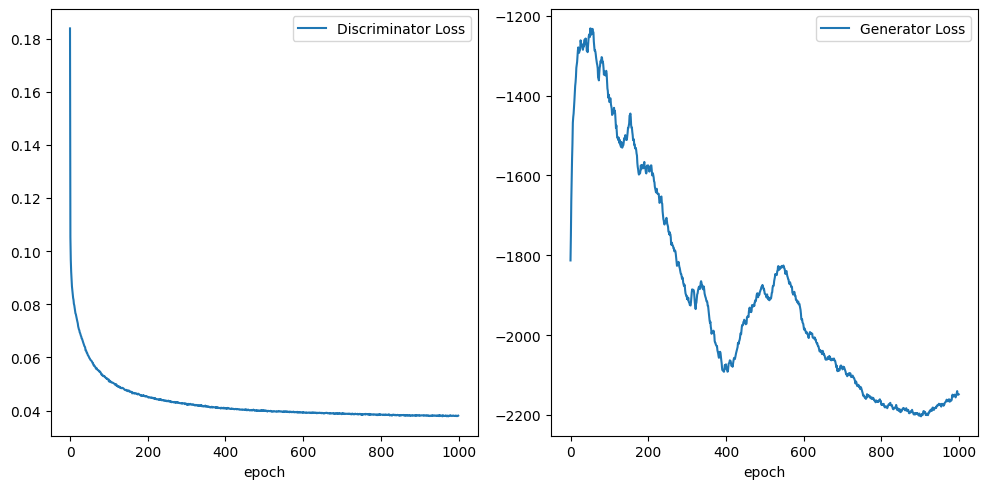

In [8]:
plt.figure(figsize=(10, 5))

# Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(crit_loss_avg, label='Discriminator Loss')
plt.xlabel('epoch')
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2)
plt.plot(gen_loss_avg, label='Generator Loss')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
gen_model_width = 150
gen_model_depth = 8
dropout_rate = 0.2
kernel_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

# Generator model
def build_generator(input_shape):
    gen_input = tf.keras.layers.Input(shape=(input_shape,))
    x = gen_input
        
    for _ in range(gen_model_depth):
        x = tf.keras.layers.Dense(gen_model_width, use_bias=False, kernel_initializer=kernel_init if _ == 0 else None)(x)
        x = tf.keras.layers.LeakyReLU(negative_slope=0.2)(x)
        x = tf.keras.layers.LayerNormalization()(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)

    outputs = tf.keras.layers.Dense(1, use_bias=False, activation='relu')(x)

    return tf.keras.models.Model(inputs=gen_input, outputs=outputs)

model_generator = build_generator(X_test_truth.shape[1])

2024-04-10 20:34:48.321164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14524 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2024-04-10 20:34:48.322776: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13924 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2024-04-10 20:34:48.324207: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14524 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2024-04-10 20:34:48.325226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13924 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id

In [16]:
model_generator.load_weights('InfiniteUnfolding/model_checkpoints/generator_epoch-0900.weights.h5')

In [17]:
weights = model_generator.predict(X_test_truth[Y_test == 0], verbose=0).flatten()

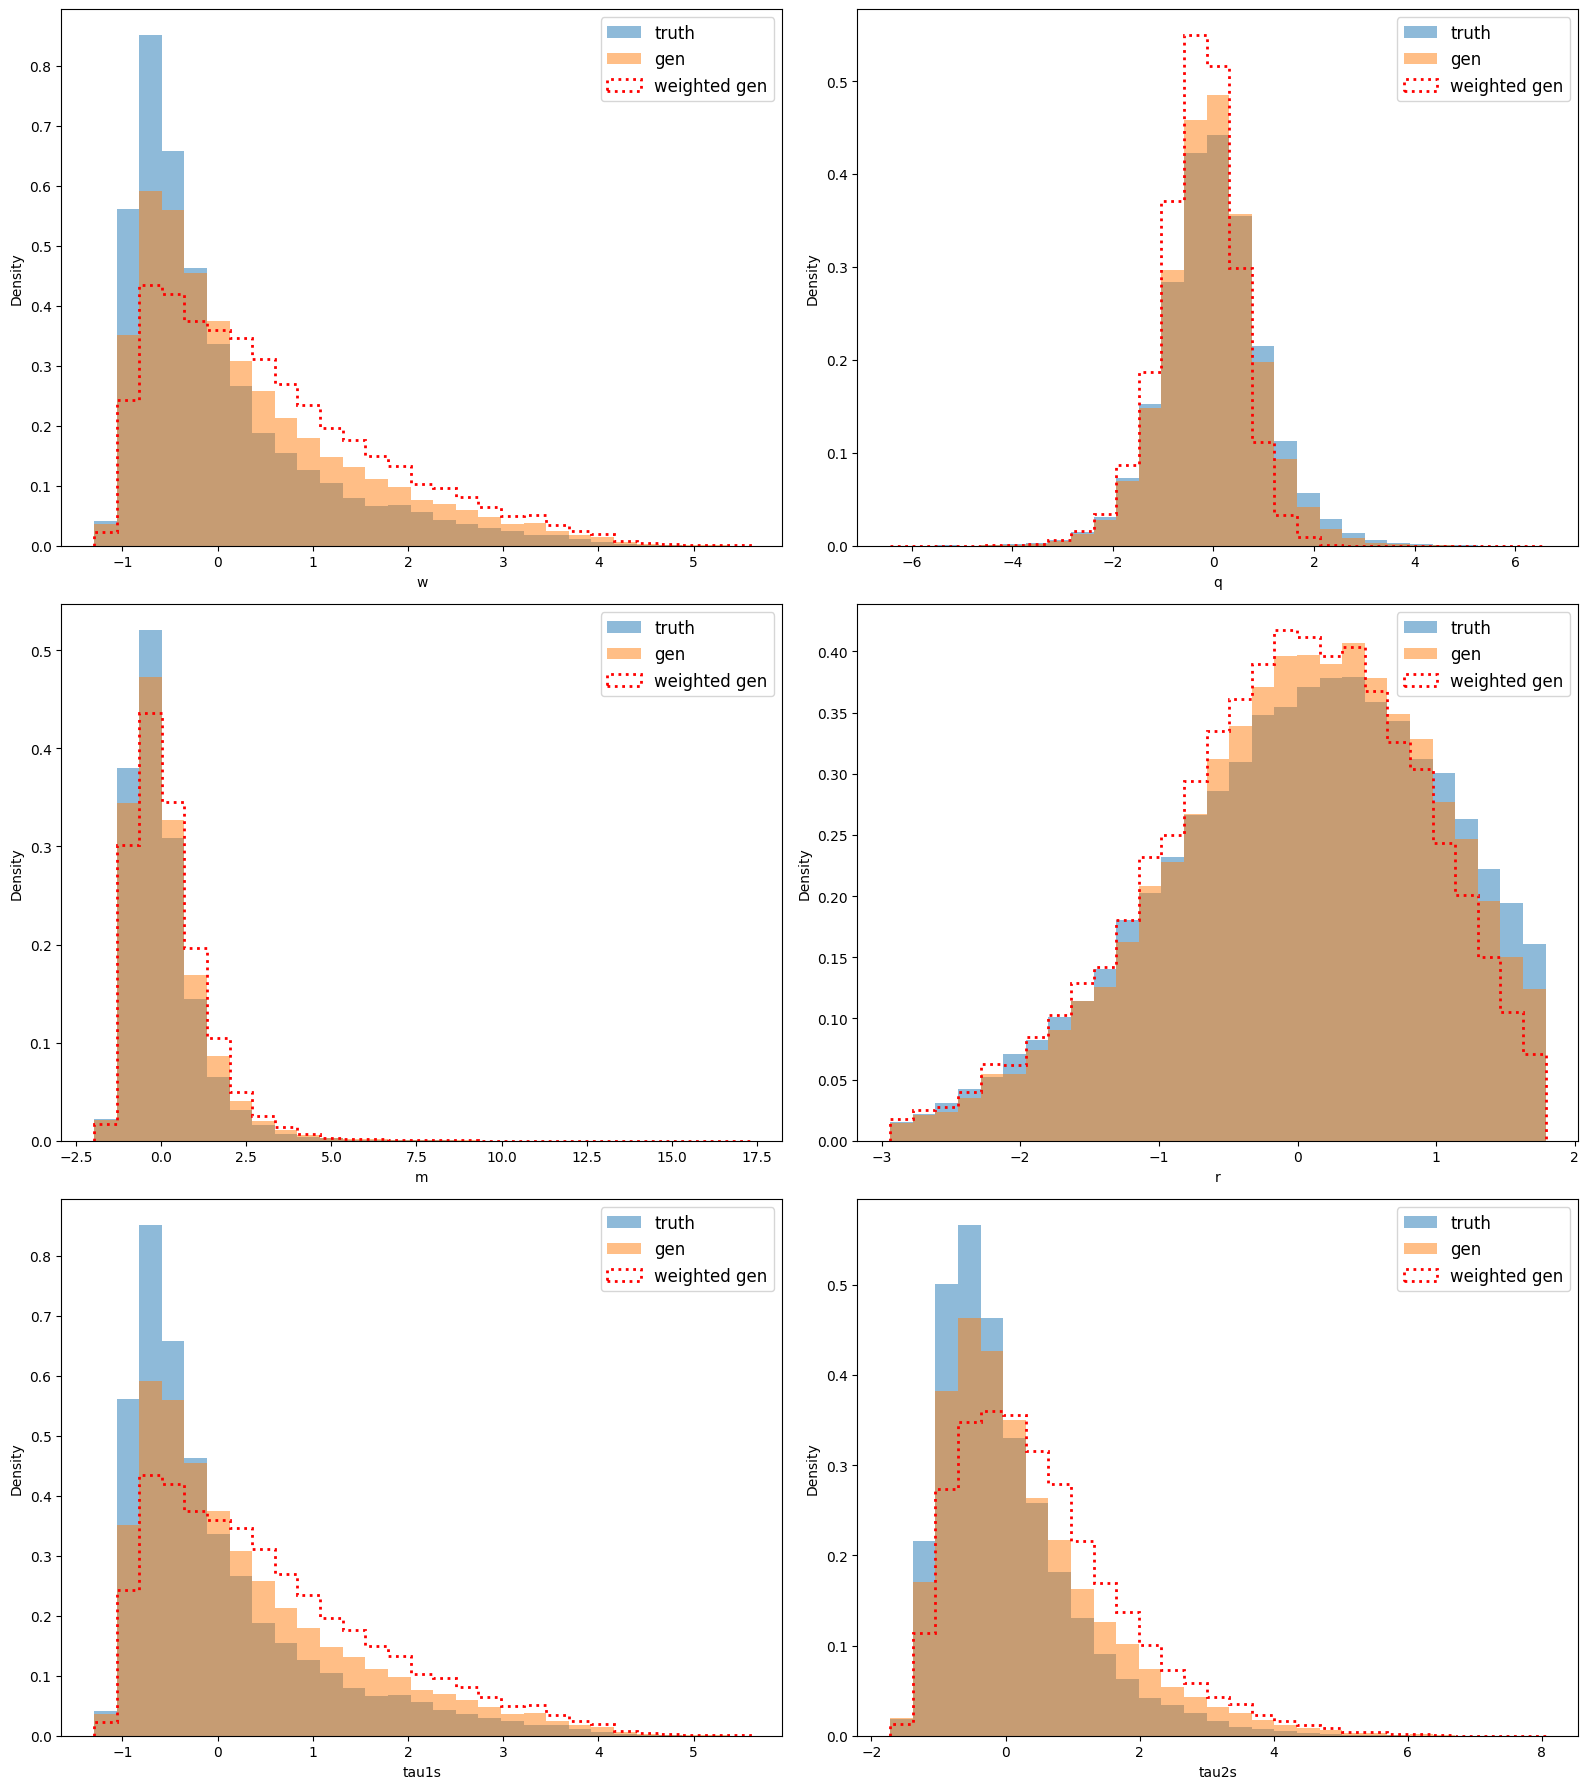

In [18]:
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
axs = axs.flatten()
nbins = 30
density = True

for i, var_name in enumerate(substructure_variables):
    X = X_test_truth[:, i]
    bins = np.linspace(X.min(), X.max(), nbins)
    
    axs[i].hist(X[Y_test == 1], bins=bins, alpha=0.5, label="truth", density=density, zorder=-1)
    axs[i].hist(X[Y_test == 0], bins=bins, alpha=0.5, label="gen", density=density, zorder=0)
    axs[i].hist(X[Y_test == 0], bins=bins, weights=weights,
                histtype="step", color="red", ls=":", lw=2, label="weighted gen", density=density, zorder=1)
    
    axs[i].legend(fontsize=12)
    axs[i].set_ylabel("Density")
    axs[i].set_xlabel(var_name)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()
